# Synthetic experiments with Monte Carlo: Examples

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# The following is specific to Jupyter Notebooks (i.e., do not copy in Spyder)
from IPython.display import set_matplotlib_formats  # makes plots in SVG instead of PNG
set_matplotlib_formats('svg')                        # makes plots in SVG instead of PNG

## The Nagel-Schreckenberg traffic model

The [Nagel-Schreckenberg traffic model](https://en.wikipedia.org/wiki/Nagel%E2%80%93Schreckenberg_model) is a simple model that predicts stop-and-go patterns we observe in traffic, even when there is no particularly bad driver around.

The idea is the following.
Time is discrete.
There are $N$ drivers.
A road is split into $M$ segments and each segment can host at most one car.
Sort the drivers $i \in \{1, \ldots, N\}$ such that $i=1$ is the last driver in the road and $i=N$ is the first driver in the road.
The road has a speed limit equal to $v_{\max}$.
Collisions between vehicles are prohibited, as well as overtaking.
Each driver moves ahead or stays in place, taking her position $x_{i,t} \in \{1, \ldots, M\}$ and adding her velocity $v_{i,t}$.
At each period $t$, every driver $i \in \{1, \ldots, N\}$ takes the following actions:

1. She checks the speed at which she was travelling, $v_{i,t-t}$. If $v_{i,t-t} < v_{\max}$, then she increases her speed by 1.
1. She checks the distance $d(x_{i,t}, x_{i+1,t})$ between herself and the driver ahead. If she is going too fast, then she reduces her speed to $d_{t}-1$ to avoid collision.
1. With some probability $p$, a given driver slows down by one velocity unit if her velocity was positive.
1. Finally, the driver moves into the next period by setting $x_{i,t+1} = x_{i,t} + v_{i,t}$.

The third step is the fundamental one in this model.
It captures the idea that each driver sometimes behaves randomly.
It is also the step that allows us to create a simulation.

In this context, a simulation is a track record of the position of each driver $i$ at each period $t$.

To create a simulation, we need three basic ingredients: an initial condition, rules to govern the behavior of variables and a source of randomness.
In the traffic model above, we described the rules of the game and the source of randomness.
We need to set an initial condition.
As we have no instruction to do so, we set it arbitrarily (just keeping in mind that one "road slot" can host only one driver).
Next, we need to code the rules, from a "narrative" form (the one above) to a formal set of instructions (in Python).
Let us translate the rules above in mathematical terms:

1. $\bar{v}_{i,t} = \min\{v_{i,t-1} + 1; v_{\max}\}$
1. $\hat{v}_{i,t} = \min\{\bar{v}_{i,t}; d(x_{i,t}, x_{i+1,t}) - 1\}$
1. $v_{i,t} = \max\{0; \hat{v}_{i,t} - 1\}$
1. $x_{i,t+1} = x_{i,t} + v_{i,t}$

We are left with two edge cases: what happens to the first driver $i=N$ when she reaches the end of the road and how we compute the distance between the first driver and the last driver $i=1$.
We will assume that if $x_{N,t} + v_{N,t} > M$, then $x_{N,t+1} = x_{N,t} + v_{N,t}$, and that $d(x_{N,t}, x_{1,t}) = M + x_{1,t} - x_{N,t}$.
This effectively represents a circular road.

Now let us turn to representing the road, the drivers and their rules in Python.
We can think of the road as a vector with $M$ elements.
In this vector, we store two values: `0` to indicate that that "road slot" has no driver in it, and `1` to indicate there is a driver at that location.
We also need to keep track of the speed of each driver.
We can do this by using another vector with $M$ elements, where we find `0` if there is no driver or the driver is waiting, or the speed `v` if the driver in that location is travelling.

The rules will be represented by a function, that takes as input the state of the road at period $t$ and returns the state of the road at period $t+1$.
This function will include all the four rules above, plus the rules governing the edge cases.
It will also include the source of randomness.

It is useful to start thinking with functions.
First, we can code the rules according to which each driver adjusts her speed.
At this stage, we can forget the edge cases.
We will simply code rules 1 to 3, almost literally.
The function we will write will take the current speed of an individual driver, the distance between that driver and the next one, the speed limit and the probability of slowing down as input arguments.
As output, we will obtain the new speed at which this individual driver will travel, taking the three rules into account.
All input and output arguments of this function are expected to be scalar integers, because they pertain an individual driver.
Rule no. 4 will be taken care of later.

In [2]:
def adjust_speed(current_speed, next_driver_distance, speed_limit, prob_slowdown):
    v_bar = np.min([current_speed + 1, speed_limit])   # rule no. 1
    v_hat = np.min([v_bar, next_driver_distance - 1])  # rule no. 2
    uniform_random_number = np.random.uniform()
    if uniform_random_number < prob_slowdown:  # rule no. 3
        v = np.max([0, v_hat - 1])
    else:
        v = v_hat
    new_speed = v
    return new_speed

Next, we code the function that considers the current state of the whole road, applies the rules above to all drivers and returns the new road, after movement occurred.
We will code here rule no. 4, including the edge cases.
This function will consider the current state of the road, the current speeds of each driver, the speed limit, the probability of slowdown as input arguments.
The output will be a vector representing the state of the road in the upcoming period.
All inputs and outputs will be vectors, with the exception of the speed limit and the slowdown probability.
Inside this function, we need to apply the `adjust_speed` function to each driver on the road.
Hence, we need a `for` loop along the road.

In [3]:
def period_transition(current_road, current_speeds, speed_limit, prob_slowdown):
    M = current_road.size
    drivers_locations = np.where(current_road == 1)[0]
    new_road = np.zeros_like(current_road, dtype=int)
    new_speeds = np.zeros_like(current_speeds, dtype=int)
    for l in drivers_locations:
        if l != drivers_locations[-1]:
            space_ahead = road[l+1] - road[l]
        else:  # hitting an edge case
            space_ahead = M - road[l] + road[drivers_locations[0]]
        new_speeds[l] = adjust_speed(current_speeds[l], space_ahead, speed_limit, prob_slowdown)
    for l in drivers_locations:
        if new_speeds[l] <= (M - 1) - l:
            new_road[l + new_speeds[l]] = 1
        else:  # hitting an edge case
            new_road[new_speeds[l] - M + l] = 1
    return (new_road, new_speeds)


Finally, we can write the code that sets up the parameters of the problem and runs the simulation over periods.
For the simulation, all we need to do is to apply the functions we wrote above, in a loop that runs from period $t=1$ to $T$.
Because Python starts counting integers from zero (as opposed to one), we will loop from `t=0` to `T-1`.

In [4]:
# Parameters of simulation
T = 1000  # no. of simulated periods


# Parameters of the model
v_max = 5  # max speed
M = 1000  # road segments
N = 50   # drivers
p = 0.3  # probability of slowing down


# Creating useful vectors with placeholder content (preallocation)
road    = np.zeros(M, dtype=int)  # an un-oriented vector
speeds  = np.zeros(M, dtype=int)  # an un-oriented vector
history_road   = np.zeros((T, M), dtype=int)  # a [T-by-M] matrix
history_speeds = np.zeros((T, M), dtype=int)  # a [T-by-M] matrix


# Creating the initial condition: equispaced drivers
initial_drivers_distance = M // N

for j in range(M):
    if j % initial_drivers_distance == 0:
        road[j] = 1


# Running the simulation
for t in range(T):
    # Save current states to histories, for track records
    history_road[t, :] = road
    history_speeds[t, :]
    # Compute the policy functions, i.e., new road state and speeds
    new_road, new_speeds = period_transition(road, speeds, v_max, p)
    # Update the model conditions for next period
    road = new_road
    speeds = new_speeds

To see the implications of the model, we can plot the history of the road state.

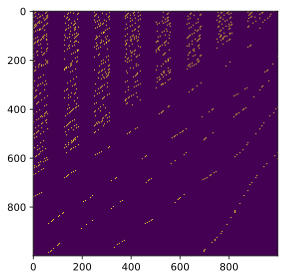

In [5]:
plt.imshow(history_road, aspect='equal')
plt.tight_layout()